In [1]:
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import tensorflow as tf
import deeppavlov
from deeppavlov.dataset_readers.ontonotes_reader import OntonotesReader

from deeppavlov.models.embedders.glove_embedder import GloVeEmbedder

/home/kostrovskiy/prog/AI/NLP/DeepPavlov/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
[nltk_data] Downloading package punkt to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/kostrovskiy/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!
2018-09-03 19:19:32.342 DEBU

In [2]:
from src.fewshot_ner_viz_component.fewshot_ner_binary_classifier import FewshotNerBinaryClassifier, CompositeEmbedder
from src.fewshot_ner_viz_component.data_processing import *

### Configuration parameters

In [3]:
NE_TYPE = 'PERSON'
N_EXAMPLES = list(range(1, 11))
N_EXAMPLES = list(range(5, 11))
# N_EXAMPLES.extend([20,30,40,50,60,70,80,90,100])
# N_EXAMPLES = list(range(10, 101, 10))
# N_EXAMPLES = list(range(1, 5))
N_TEST_SENTENCES = 100
N_SAMPLES = 1
# MODELS = ['ne_centroid', 'ne_nearest', 'weighted_kNN', 'centroid_kNN', 'svm']
MODELS = ['ne_centroid', 'ne_nearest', 'weighted_kNN', 'centroid_kNN', 'svm']
MODELS = ['ne_centroid', 'weighted_kNN', 'centroid_kNN', 'svm']
MODELS = ['svm']
# MODELS = ['ne_centroid', 'weighted_kNN', 'centroid_kNN', 'svm']
MODEL_PARAMS = {'ne_centroid': {'sim_type': 'cosine'},
               'ne_nearest': {'sim_type': 'cosine'},
               'weighted_kNN': {'k': 1, 'metric': 'cosine', 'use_class_weights': False, 'use_sim_weights': True},
               'centroid_kNN': {'k': 10, 'metric': 'dot_prod', 'use_class_weights': False},
               'svm': {}}

In [4]:
dataset_orig = read_data()

Num of train sentences: 75187
Num of valid sentences: 9603
Num of test sentences: 9479
[(['Actions', 'had', 'to', 'be', 'taken', 'to', 'break', 'through', 'the', 'blockade', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'a', 'night', 'in', 'late', 'July', '1940', ',', 'the', 'atmosphere', 'in', 'Zhuanbi', 'Village', 'in', 'Shaanxi', 'was', 'unusual', '.'], ['O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'B-GPE', 'I-GPE', 'O', 'B-GPE', 'O', 'O', 'O']), (['Villager', 'Xiao', 'Jianghe', 'has', 'a', 'vivid', 'memory', 'of', 'this', 'piece', 'of', 'history', '.'], ['O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'that', 'dark', 'night', ',', 'everyone', 'was', 'sleeping', 'when', 'human', 'voices', 'and', 'neighing', 'horses', 'were', 'heard', 'within', 'the', 'village', '.'], ['O', 'B-TIME', 'I-TIME', 'I-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [5]:
# embedder = CompositeEmbedder(use_elmo=True, elmo_scale=1, cap_scale=1, use_cap_feat=True, use_glove=True, elmo_params={'trainable_cells': True, 'restore_path': "./tmp/elmo.ckpt"})
# embedder = CompositeEmbedder(use_elmo=True, elmo_scale=1, cap_scale=1, use_cap_feat=True, use_glove=True)
embedder = CompositeEmbedder(use_elmo=False, elmo_scale=1, cap_scale=1, use_cap_feat=False, use_glove=False, use_fastText=True)

2018-09-03 19:19:45.252 INFO in 'deeppavlov.models.embedders.fasttext_embedder'['fasttext_embedder'] at line 69: [loading embeddings from `/home/kostrovskiy/prog/AI/NLP/DeepPavlov/download/embeddings/wiki.en.bin`]


In [6]:
from collections import defaultdict
f1_scores = {}
print('NE type: {}'.format(NE_TYPE))
dataset = filter_dataset_by_ne_types(dataset_orig, NE_TYPE, preserveBIO=True)
for n_ex in N_EXAMPLES:
    print('++++++++ Number of example sentences: {} ++++++++'.format(n_ex))
    f1_scores[n_ex] = {}
    for model in MODELS:
        f1_scores[n_ex][model] = {'values':[], 'values_chunk':[]}
    for idx_sample in range(N_SAMPLES):
        print('Sample {}'.format(idx_sample+1))
        tokens_train,tags_train = get_data_sample(dataset['train'], n_ex)
        tags_train = removeBIOFromTags(tags_train)
        tokens_test,tags_test = get_data_sample(dataset['test'], N_TEST_SENTENCES)
        tags_test_bio = tags_test
        tags_test_bio_flat = flatten_list(tags_test_bio)
        tags_test = removeBIOFromTags(tags_test)
        y_test = np.array([1 if t == 'T' else 0 for seq in tags_test for t in seq])
        ner_bin_clf = FewshotNerBinaryClassifier(embedder)
        ner_bin_clf.train_on_batch(tokens_train, tags_train)
        results = ner_bin_clf.predict(tokens_test, MODELS, MODEL_PARAMS)
        pred_avg = np.zeros(y_test.size)
        n_models_avg = 0
        for model in MODELS:
            pred = results[model]['pred']
            if model in ['ne_centroid', 'weighted_kNN', 'centroid_kNN', 'svm']:   
                pred_avg += pred
                n_models_avg += 1
            f1 = f1_score(y_test, pred)
            f1_scores[n_ex][model]['values'].append(f1)
            # chunk-wise f1
            pred_tags_bio = predToTags(pred, accountBIO=True)
            f1_chunk = precision_recall_f1_chunks(tags_test_bio_flat, pred_tags_bio, print_results=False)['__total__']['f1']/100
            f1_scores[n_ex][model]['values_chunk'].append(f1_chunk)
        pred_avg /= n_models_avg
        
        cur_f1_scores_dict = {k: f1_scores[n_ex][k]['values'][-1] for k in f1_scores[n_ex].keys()}
        print('F1 scores: {}'.format(cur_f1_scores_dict))
        
        del ner_bin_clf
    for model in MODELS:
        f1_scores[n_ex][model]['mean'] = np.mean(f1_scores[n_ex][model]['values'])
        f1_scores[n_ex][model]['std'] = np.std(f1_scores[n_ex][model]['values'])
        f1_scores[n_ex][model]['mean_chunk'] = np.mean(f1_scores[n_ex][model]['values_chunk'])
        f1_scores[n_ex][model]['std_chunk'] = np.std(f1_scores[n_ex][model]['values_chunk'])
        print('{} F1: mean = {} std = {}'.format(model, f1_scores[n_ex][model]['mean'], f1_scores[n_ex][model]['std']))
        print('{} F1: mean_chunk = {} std_chunk = {}'.format(model, f1_scores[n_ex][model]['mean_chunk'], f1_scores[n_ex][model]['std_chunk']))

NE type: PERSON
Num of train sentences: 12195
Num of valid sentences: 1553
Num of test sentences: 1573
++++++++ Number of example sentences: 5 ++++++++
Sample 1
Train
# ne: 13, # tokens: 126
n_samples: 126
SVM classifier model
F1 scores: {'svm': 0.3057851239669422}
svm F1: mean = 0.3057851239669422 std = 0.0
svm F1: mean_chunk = 0.16249999999999998 std_chunk = 0.0
++++++++ Number of example sentences: 6 ++++++++
Sample 1
Train
# ne: 11, # tokens: 153
n_samples: 153
SVM classifier model
F1 scores: {'svm': 0.2162162162162162}
svm F1: mean = 0.2162162162162162 std = 0.0
svm F1: mean_chunk = 0.08917197452229299 std_chunk = 0.0
++++++++ Number of example sentences: 7 ++++++++
Sample 1
Train
# ne: 13, # tokens: 247
n_samples: 247
SVM classifier model
F1 scores: {'svm': 0.6461538461538462}
svm F1: mean = 0.6461538461538462 std = 0.0
svm F1: mean_chunk = 0.4761904761904761 std_chunk = 0.0
++++++++ Number of example sentences: 8 ++++++++
Sample 1
Train
# ne: 12, # tokens: 178
n_samples: 178
SVM

In [7]:
f1_by_model = {}
f1_chunk_by_model = {}
for n_ex, results in f1_scores.items():
    for model in results.keys():
        if not f1_by_model.get(model):  
            f1_by_model[model] = []
            f1_chunk_by_model[model] = []
        f1_by_model[model].append(results[model]['mean'])
        f1_chunk_by_model[model].append(results[model]['mean_chunk'])

Text(0.5,1,'Average F1 scores')

2018-09-03 19:21:19.626 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1343: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/kostrovskiy/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-09-03 19:21:19.722 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1343: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/kostrovskiy/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


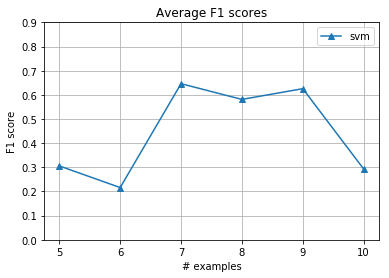

In [8]:
markers = ['^', 'x', 'v', 'o', 's']
markers = ['^', 'v', 'o', 's']
fig = plt.figure()
i = 0
for model, f1_scores_list in f1_by_model.items():
    ax = plt.plot(N_EXAMPLES, f1_scores_list, marker=markers[i], label=model)
    i += 1
plt.grid()
plt.xticks(N_EXAMPLES)
plt.yticks(np.arange(0,0.95,0.1))
plt.xlabel('# examples')
plt.ylabel('F1 score')
plt.legend()
plt.title('Average F1 scores')

### Token-wise vs chunk-wise F1 scores

Text(0.5,1,'Average F1 scores for SVM: token-wise vs chunk-wise')

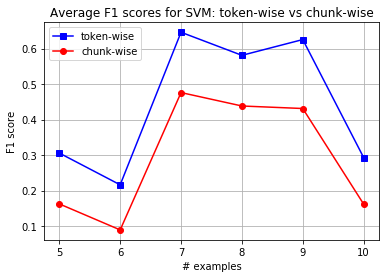

In [9]:
fig = plt.figure()
plt.plot(N_EXAMPLES, f1_by_model['svm'], marker='s', c='b', label='token-wise')
plt.plot(N_EXAMPLES, f1_chunk_by_model['svm'], marker='o', c='r', label='chunk-wise')
plt.grid()
plt.xticks(N_EXAMPLES)
plt.xlabel('# examples')
plt.ylabel('F1 score')
plt.legend()
plt.title('Average F1 scores for SVM: token-wise vs chunk-wise')

In [10]:
fig = plt.figure()
plt.plot(N_EXAMPLES, f1_by_model['weighted_kNN'], marker='s', c='b', label='token-wise')
plt.plot(N_EXAMPLES, f1_chunk_by_model['weighted_kNN'], marker='o', c='r', label='chunk-wise')
plt.grid()
plt.xticks(N_EXAMPLES)
plt.xlabel('# examples')
plt.ylabel('F1 score')
plt.legend()
plt.title('Average F1 scores for kNN: token-wise vs chunk-wise')

KeyError: 'weighted_kNN'

<Figure size 432x288 with 0 Axes>